In [3]:
from pathlib import Path

import numpy as np
import pandas as pd

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_df = engineer_features(sorted_dyads_df)
cleaned_dyads_df = pd.concat(list(cleaned_dyads_df.values()), axis=1)

df_train = cleaned_dyads_df[cleaned_dyads_df["Arm_Sham"]]
df_test = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_3464/119375757.py:9: DtypeWarning: Columns (95,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:135: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


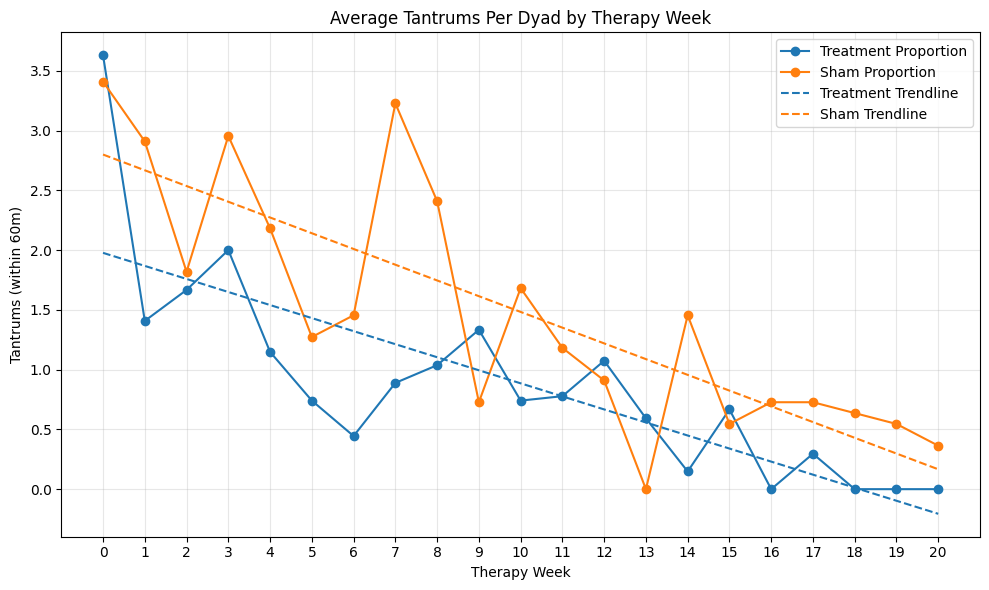

In [4]:
import matplotlib.pyplot as plt
import numpy as np

week_cutoff = 20
test_tantrum_proportion = (
    df_test.groupby("therapy_week")["tantrum_within_60m"].sum()
    / df_test["dyad"].nunique()
)
test_tantrum_proportion = test_tantrum_proportion[
    test_tantrum_proportion.index <= week_cutoff
]

train_tantrum_proportion = (
    df_train.groupby("therapy_week")["tantrum_within_60m"].sum()
    / df_train["dyad"].nunique()
)
train_tantrum_proportion = train_tantrum_proportion[
    train_tantrum_proportion.index <= week_cutoff
]

test_tantrum_proportion = test_tantrum_proportion[test_tantrum_proportion.index >= 0]
train_tantrum_proportion = train_tantrum_proportion[train_tantrum_proportion.index >= 0]

plt.figure(figsize=(10, 6))
plt.plot(
    test_tantrum_proportion.index,
    test_tantrum_proportion.values,
    label="Treatment Proportion",
    marker="o",
)
plt.plot(
    train_tantrum_proportion.index,
    train_tantrum_proportion.values,
    label="Sham Proportion",
    marker="o",
)

# Add trendlines
z_test = np.polyfit(test_tantrum_proportion.index, test_tantrum_proportion.values, 1)
p_test = np.poly1d(z_test)
plt.plot(
    test_tantrum_proportion.index,
    p_test(test_tantrum_proportion.index),
    label="Treatment Trendline",
    linestyle="--",
    color="tab:blue",
)

z_train = np.polyfit(train_tantrum_proportion.index, train_tantrum_proportion.values, 1)
p_train = np.poly1d(z_train)
plt.plot(
    train_tantrum_proportion.index,
    p_train(train_tantrum_proportion.index),
    label="Sham Trendline",
    linestyle="--",
    color="tab:orange",
)

plt.xlabel("Therapy Week")
plt.xticks(np.arange(0, week_cutoff + 1, 1))
plt.ylabel("Tantrums (within 60m)")
plt.title("Average Tantrums Per Dyad by Therapy Week")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from flaml import AutoML
from sklearn.model_selection import TimeSeriesSplit

time_series_split = TimeSeriesSplit()
automl = AutoML()


automl_settings = {
    "time_budget": 60,  # seconds
    "train_time_limit": 1,  # seconds
    "task": "classification",
    "metric": "log_loss",
    "estimator_list": ["xgboost"],
    # "split_type": time_series_split,
    "early_stop": True,
}


X_train, y_train = prep_X_y(df_train, "tantrum_within_15m")
X_test, y_test = prep_X_y(df_test, "tantrum_within_15m")

automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
print("Best config:", automl.best_config)

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

from hr_model import HrModel

positive_model = DummyClassifier(strategy="constant", constant=1).fit(X_train, y_train)
y_hat_positive = positive_model.predict(X_test)
print("Positive Model ROC-AUC:", roc_auc_score(y_test, y_hat_positive))

y_hat_hr = HrModel().predict(X_test)
print("HR Model ROC-AUC:", roc_auc_score(y_test, y_hat_hr))

model = automl
y_hat = model.predict_proba(X_test)
print("XGB ROC-AUC:", roc_auc_score(y_test, y_hat[:, 1]))

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score

positive_model = DummyClassifier(strategy="constant", constant=1).fit(X_train, y_train)
y_hat_positive = positive_model.predict(X_test)
print(
    "Positive Model average precision:", average_precision_score(y_test, y_hat_positive)
)

y_hat_hr = HrModel().predict(X_test)
print("HR Model average precision:", average_precision_score(y_test, y_hat_hr))

model = automl
y_hat = model.predict_proba(X_test)
print("XGB average precision:", average_precision_score(y_test, y_hat[:, 1]))

In [ ]:
from sklearn.metrics import precision_score, recall_score


def specificity(y_true, y_pred):
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    if (tn + fp) == 0:
        return float("nan")
    return tn / (tn + fp)


y_pred_hr = HrModel().predict(X_test)
precision = precision_score(y_test, y_pred_hr)
recall = recall_score(y_test, y_pred_hr)
spec = specificity(y_test, y_pred_hr)

print(
    f"HR range: Precision: {precision:.4f}, Recall/Sensitivity: {recall:.4f}, Specificity: {spec:.4f}"
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import FixedThresholdClassifier, StratifiedKFold
from xgboost import XGBClassifier


def find_threshold_ref_precision(model, X, y, *, verbose=False) -> float:
    hr_model = HrModel()

    ref_y_pred = hr_model.predict(X)
    ref_precision = precision_score(y, ref_y_pred, zero_division=np.nan)
    ref_recall = recall_score(y, ref_y_pred, zero_division=np.nan)

    y_pred_proba = model.predict_proba(X)
    thresholds = np.logspace(-10, 0, 100)

    for th in thresholds:
        y_pred = (y_pred_proba[:, 1] >= th).astype(int)
        precision = precision_score(y, y_pred, zero_division=np.nan)
        recall = recall_score(y, y_pred, zero_division=np.nan)
        if precision >= ref_precision:
            if verbose:
                print(f"Selected threshold: {th}")
                print(f"Selected precision: {precision}, recall: {recall}")
                print(f"Reference precision: {ref_precision}, recall: {ref_recall}")
            return th

    raise ValueError("No suitable threshold found!")


def find_threshold_youden(model, X, y, *, verbose=False) -> float:
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    youden_index = tpr - fpr
    best_threshold_index = np.argmax(youden_index)
    best_threshold = thresholds[best_threshold_index]

    if y.sum() == 0:
        raise ValueError("No positive samples in y.")

    if verbose:
        print(f"Best threshold: {best_threshold:.4f}")
        y_pred = (y_pred_proba >= best_threshold).astype(int)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")

    return best_threshold


def find_threshold_youden_cv(model, X, y, n_splits, verbose=False):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    thresholds = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        th = find_threshold_youden(model, X_val, y_val, verbose=verbose)
        thresholds.append(th)
    best_threshold = float(np.mean(thresholds))
    if verbose:
        print(f"Cross-validated best threshold: {best_threshold:.4f}")
    return best_threshold


def find_threshold_ref_precision_cv(model, X, y, n_splits, verbose=False):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    thresholds = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        th = find_threshold_ref_precision(model, X_val, y_val, verbose=verbose)
        thresholds.append(th)
    best_threshold = float(np.mean(thresholds))
    if verbose:
        print(f"Cross-validated best threshold: {best_threshold:.4f}")
    return best_threshold


model = XGBClassifier(**automl.best_config)
# threshold = find_threshold_youden_cv(model, X_train, y_train, n_splits=5, verbose=True)
threshold = find_threshold_ref_precision_cv(
    model, X_train, y_train, n_splits=5, verbose=True
)
y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
spec = specificity(y_test, y_pred)

print()
print(
    f"Precision: {precision:.4f}, Recall/Sensitivity: {recall:.4f}, Specificity: {spec:.4f}"
)

tuned_model = FixedThresholdClassifier(model, threshold=threshold)

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

precision, recall, pr_thresholds = precision_recall_curve(
    y_test, model.predict_proba(X_test)[:, 1]
)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from typing import Any

import xgboost as xgb
from sklearn.model_selection import FixedThresholdClassifier
from tqdm.auto import tqdm


def train_model(df_train):
    X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
    model = xgb.XGBClassifier(**automl.best_config)
    model.fit(X_train, y_train)
    threshold = find_threshold_ref_precision_cv(
        model, X_train, y_train, n_splits=2, verbose=False
    )
    model = FixedThresholdClassifier(model, threshold=threshold)
    return model


def bootstrap(df: pd.DataFrame, n_samples: int) -> pd.DataFrame:
    boot_df = pd.DataFrame()
    for _ in range(n_samples):
        boot_df = pd.concat(
            [
                boot_df,
                df.sample(frac=1, replace=True, random_state=None),
            ]
        )
    return boot_df


def train_and_get_dyad_models(
    df_population: pd.DataFrame,
    df_test: pd.DataFrame,
    mode: str,
    week: int,
    dyad_models: dict[str, Any],
):
    min_week = df_test["therapy_week"].min()
    if week == min_week:
        return dyad_models

    new_dyad_models = {}
    bootstrap_level = df_test["dyad"].nunique()
    match mode:
        case "no_retrain":
            return dyad_models
        case "retrain_dyad":
            for dyad, dyad_df in df_test.groupby("dyad"):
                add_df = dyad_df[dyad_df["therapy_week"] < week]
                add_df = bootstrap(add_df, bootstrap_level)

                df_train_concat = pd.concat([df_population, add_df])
                new_dyad_models[dyad] = train_model(df_train_concat)
        case _:
            raise ValueError(f"Unknown mode: {mode}")

    return new_dyad_models


def retrain_and_predict(
    base_model, df_train: pd.DataFrame, df_test: pd.DataFrame, mode: str
):
    dyad_models = {d: base_model for d in df_test["dyad"].unique()}
    weekly_results = []
    weeks = df_test["therapy_week"].unique()
    weeks_iter = sorted(weeks[weeks >= 0])
    for week in tqdm(weeks_iter):
        dyad_models = train_and_get_dyad_models(
            df_train, df_test, mode, week, dyad_models=dyad_models
        )
        week_df = df_test[df_test["therapy_week"] == week]

        week_pred_proba = np.empty((0, 2))
        week_preds = np.array([])
        week_trues = np.array([])
        week_thresholds = np.array([])
        for dyad, dyad_week_df in week_df.groupby("dyad"):
            X, y = prep_X_y(dyad_week_df, "tantrum_within_60m")
            model = dyad_models[dyad]

            y_pred_proba = model.predict_proba(X)
            y_pred = model.predict(X)

            week_pred_proba = np.concatenate([week_pred_proba, y_pred_proba])
            week_preds = np.concatenate([week_preds, y_pred])
            week_trues = np.concatenate([week_trues, y.values])
            threshold = (
                model.threshold if isinstance(model, FixedThresholdClassifier) else 0.5
            )
            week_thresholds = np.append(week_thresholds, threshold)

        weekly_results.append(
            (week, week_pred_proba, week_preds, week_trues, week_thresholds)
        )
    return weekly_results

In [ ]:
positive_model_results = retrain_and_predict(
    positive_model, df_train, df_test, mode="no_retrain"
)

In [ ]:
hr_model_results = retrain_and_predict(HrModel(), df_train, df_test, mode="no_retrain")

In [ ]:
no_retrain_results = retrain_and_predict(
    tuned_model, df_train, df_test, mode="no_retrain"
)

In [ ]:
retrain_dyad_results = retrain_and_predict(
    tuned_model, df_train, df_test, mode="retrain_dyad"
)

In [ ]:
import pickle

data_dir = Path("./intermediate_data")
data_dir.mkdir(exist_ok=True)

with open(data_dir / "positive_model_results.pkl", "wb") as f:
    pickle.dump(positive_model_results, f)

with open(data_dir / "hr_model_results.pkl", "wb") as f:
    pickle.dump(hr_model_results, f)

with open(data_dir / "no_retrain_results.pkl", "wb") as f:
    pickle.dump(no_retrain_results, f)

with open(data_dir / "retrain_dyad_results.pkl", "wb") as f:
    pickle.dump(retrain_dyad_results, f)


# Analysis


In [ ]:
import pickle
from pathlib import Path

data_dir = Path("./intermediate_data")
with open(data_dir / "positive_model_results.pkl", "rb") as f:
    positive_model_results = pickle.load(f)

with open(data_dir / "hr_model_results.pkl", "rb") as f:
    hr_model_results = pickle.load(f)

with open(data_dir / "no_retrain_results.pkl", "rb") as f:
    no_retrain_results = pickle.load(f)

with open(data_dir / "retrain_dyad_results.pkl", "rb") as f:
    retrain_dyad_results = pickle.load(f)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import recall_score, roc_auc_score


def get_weekly_roc_auc(results):
    aucs = []
    for week, y_pred_proba, _, y_true in results:
        if len(set(y_true)) > 1:
            auc = roc_auc_score(y_true, y_pred_proba[:, 1])
        else:
            auc = float("nan")
        aucs.append((week, auc))
    return aucs


hr_auc = get_weekly_roc_auc(hr_model_results)
no_retrain_auc = get_weekly_roc_auc(no_retrain_results)
retrain_auc = get_weekly_roc_auc(retrain_dyad_results)

plt.figure(figsize=(10, 6))

# Plot lines
plt.plot(*zip(*hr_auc), label="HR range (105-129)")
plt.plot(*zip(*no_retrain_auc), label="XGB static")
plt.plot(*zip(*retrain_auc), label="XGB retrain weekly")


# Add trendlines for each model
def plot_trendline(auc, color):
    weeks, values = zip(*auc)
    weeks = np.array(weeks)
    values = np.array(values)
    mask = ~np.isnan(values)
    if np.sum(mask) > 1:
        z = np.polyfit(weeks[mask], values[mask], 1)
        p = np.poly1d(z)
        plt.plot(weeks[mask], p(weeks[mask]), linestyle="--", color=color)


plot_trendline(hr_auc, "tab:blue")
plot_trendline(no_retrain_auc, "tab:orange")
plot_trendline(retrain_auc, "tab:green")

plt.xlabel("Therapy Week")
plt.ylabel("ROC AUC")
plt.title("Weekly ROC AUC by Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'hr_model_results' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score


# Ability to identify negative cases (true neg / predicted neg)
def specificity_score(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    if (tn + fp) == 0:
        return float("nan")
    return tn / (tn + fp)


metric = specificity_score


def plot_weekly_metric(metric_name, metric_fn):
    def weekly_metric(results):
        metrics = []
        for week, y_pred_proba, y_pred, y_true in results:
            if len(set(y_true)) > 1:
                # y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
                metric = metric_fn(y_true, y_pred)
            else:
                metric = float("nan")
            metrics.append((week, metric))
        return metrics

    hr_metric = weekly_metric(hr_model_results)
    no_retrain_metric = weekly_metric(no_retrain_results)
    retrain_metric = weekly_metric(retrain_dyad_results)

    plt.figure(figsize=(10, 6))

    # Plot lines
    plt.plot(*zip(*hr_metric), label="HR static (105-129)")
    plt.plot(*zip(*no_retrain_metric), label="XGB static")
    plt.plot(*zip(*retrain_metric), label="XGB retrain weekly")

    # Add trendlines for each model
    def plot_trendline(metric, color):
        weeks, values = zip(*metric)
        weeks = np.array(weeks)
        values = np.array(values)
        mask = ~np.isnan(values)
        if np.sum(mask) > 1:
            z = np.polyfit(weeks[mask], values[mask], 1)
            p = np.poly1d(z)
            plt.plot(weeks[mask], p(weeks[mask]), linestyle="--", color=color)

    plot_trendline(hr_metric, "tab:blue")
    plot_trendline(no_retrain_metric, "tab:orange")
    plot_trendline(retrain_metric, "tab:green")

    plt.xlabel("Therapy Week")
    plt.ylabel(f"{metric_name}")
    plt.title(f"Weekly {metric_name} by Model")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_weekly_metric("Sensitivity", recall_score)
plot_weekly_metric("Specificity", specificity_score)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


def get_cumulative_roc_auc(results):
    aucs = []
    all_y_pred_proba = np.empty((0, 2))
    all_y_pred = np.array([])
    all_y_true = np.array([])
    for week, y_pred_proba, y_pred, y_true in results:
        # For coin flip, y_pred_proba may contain -1, clip to [0, 1]
        all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
        all_y_pred = np.concatenate([all_y_pred, y_pred])
        all_y_true = np.concatenate([all_y_true, y_true])
        # Only compute if there are both classes present
        if len(set(all_y_true)) > 1:
            auc = roc_auc_score(all_y_true, all_y_pred_proba[:, 1])
        else:
            auc = float("nan")
        aucs.append((week, auc))
    return aucs


hr_cum_auc = get_cumulative_roc_auc(hr_model_results)
no_retrain_cum_auc = get_cumulative_roc_auc(no_retrain_results)
retrain_cum_auc = get_cumulative_roc_auc(retrain_dyad_results)

plt.figure(figsize=(10, 6))
plt.plot(*zip(*hr_cum_auc), label="HR range (105-129)")
plt.plot(*zip(*no_retrain_cum_auc), label="No Retrain")
plt.plot(*zip(*retrain_cum_auc), label="Retrain Weekly")
plt.xlabel("Therapy Week")
plt.ylabel("Cumulative ROC-AUC")
plt.title("Cumulative ROC-AUC by Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

-   why do we see the greatest ROC-AUC improvement in the first 5 weeks vs 10, 15, 20?
    -   new physio indiv. to child?
    -   tantrum distribution?
    -   does the biggest change in physio for PCIT happen in the first 5 weeks?
    -   e.g., sleep better, HR lower?


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


def plot_weekly_cum_metric(metric_name, metric_fn):
    def weekly_cum_metric(results, metric_fn):
        metrics = []
        all_y_pred_proba = np.empty((0, 2))
        all_y_pred = np.array([])
        all_y_true = np.array([])
        for week, y_pred_proba, y_pred, y_true in results:
            all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
            all_y_pred = np.concatenate([all_y_pred, y_pred])
            all_y_true = np.concatenate([all_y_true, y_true])
            # Only compute if there are both classes present
            if len(set(all_y_true)) > 1:
                metric = metric_fn(all_y_true, all_y_pred)
            else:
                metric = float("nan")
            metrics.append((week, metric))
        return metrics

    hr_cum_auc = weekly_cum_metric(hr_model_results, metric_fn)
    no_retrain_cum_auc = weekly_cum_metric(no_retrain_results, metric_fn)
    retrain_cum_auc = weekly_cum_metric(retrain_dyad_results, metric_fn)

    plt.figure(figsize=(10, 6))
    plt.plot(*zip(*hr_cum_auc), label="HR range (105-129)")
    plt.plot(*zip(*no_retrain_cum_auc), label="No Retrain")
    plt.plot(*zip(*retrain_cum_auc), label="Retrain Dyad")
    plt.xlabel("Therapy Week")
    plt.ylabel(f"Cumulative {metric_name}")
    plt.title(f"Cumulative {metric_name} by Model")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_weekly_cum_metric("Sensitivity", recall_score)
plot_weekly_cum_metric("Specificity", specificity_score)